In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.metrics import r2_score
from lmfit import Parameters, minimize, fit_report
from scipy.optimize import curve_fit
from lmfit.models import PowerLawModel

# Global plot parameters
plt.rcParams.update({'font.size':20, 'lines.markersize':9})
plt.rcParams.update({'mathtext.fontset':'cm'})
plt.rcParams.update({'font.family':'Times New Roman'})


In [2]:
def power_fit_lmfit(params, x, y):
        a = params['a']
        b = params['b']
        y_fit = a*x**b
        
        return y_fit-y

def func_powerlaw(x, a, b):
        return a*x**b

In [3]:
def calc_rsquared(x, y, amplitude, exponent):
    yhat = func_powerlaw(x, amplitude, exponent)

    return r2_score(y, yhat)

In [4]:
dataBase_path = r'./'
dataBase_file = r'UUVDatabase.xlsx'
biological_file = r'biological_COT_Data.ods'
gazzola_file = r'Gazzola Data.ods'
AUV_file = r'AUV_Sw_scaling.ods'

In [5]:
data_path = Path(dataBase_path, dataBase_file)
bcfDF = pd.read_excel(data_path, sheet_name = 'BCF')
mpfDF = pd.read_excel(data_path, sheet_name='MPF')
convDF = pd.read_excel(data_path, sheet_name = 'Propeller')
liftDF = pd.read_excel(data_path, sheet_name="LiftBased")

data_path = Path(dataBase_path, biological_file)
bio_kinematics = pd.read_excel(data_path, sheet_name='Videler Kinematic')

In [6]:
bio = pd.DataFrame({'Sw':bio_kinematics['Sw'].values, 'Re':bio_kinematics['Re'].values})
bcf = pd.DataFrame({'Actuator':bcfDF['Actuator'], 'Sw': bcfDF['Sw'].values, 'Re':bcfDF['Re'].values})
mpf = pd.DataFrame({'Sw': mpfDF['Sw'].values, 'Re':mpfDF['Re'].values})
lift = pd.DataFrame({'Sw': liftDF['Sw'].values, 'Re':liftDF['Re'].values})

# do some data conditioning
bio.dropna( inplace=True)
bcf.dropna( inplace=True)
mpf.dropna( inplace=True)
lift.dropna( inplace=True)

bio = bio.loc[~(bio==0).any(axis=1)]
bcf = bcf.loc[~(bcf==0).any(axis=1)]
mpf = mpf.loc[~(mpf==0).any(axis=1)]
lift = lift.loc[~(lift==0).any(axis=1)]

# sort the column values in ascending order
bio.sort_values('Sw', inplace=True)
bcf.sort_values('Sw', inplace=True)
mpf.sort_values('Sw', inplace=True)
lift.sort_values('Sw', inplace=True)

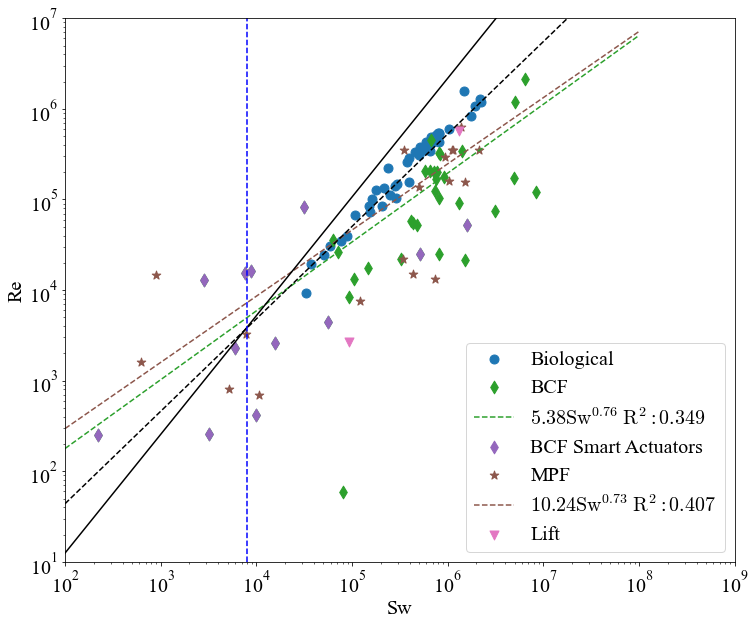

In [7]:
# plot Reynolds number and SW
fig1, ax1 = plt.subplots(figsize=(12,10), facecolor='w')

dx = np.linspace(1e2, 1e8)

bcf_smart = bcf[~bcf['Actuator'].isin(['Motor', 'Servo'])]

bcf_high = bcf[bcf['Sw'] >= 1e4]
bcf_low = bcf[bcf['Sw'] < 1e4]

mpf_high = mpf[mpf['Sw'] >= 1e4]
mpf_low = mpf[mpf['Sw'] < 1e4]

model = PowerLawModel(prefix='p_')
pars = model.guess(bcf_high['Re'].values, x=bcf_high['Sw'].values)
pars['p_amplitude'].set(value=0.4, min=0.0001, max=500.0)
pars['p_exponent'].set(value=1.02, min=0.0001, max=1.5)

bcf_sw_fit = model.fit(bcf_high['Re'].values, pars, x=bcf_high['Sw'])
mpf_sw_fit = model.fit(mpf_high['Re'].values, pars, x=mpf_high['Sw'])

ax1.scatter(bio['Sw'].values, bio['Re'].values, marker='o', color='C0', label='Biological')
ax1.scatter(bcf['Sw'].values, bcf['Re'].values, marker='d', color='C2', label='BCF')
ax1.plot(dx, bcf_sw_fit.params['p_amplitude'].value*dx**bcf_sw_fit.params['p_exponent'].value, 'C2--', label='$\mathrm{' + str(np.round(bcf_sw_fit.params['p_amplitude'].value, 2)) + 
         'Sw^{' + str(np.round(bcf_sw_fit.params['p_exponent'].value, 2)) + '}\;R^2: ' + str(np.round(1 - bcf_sw_fit.redchi / np.var(bcf_high['Re'].values, ddof=2), 3)) + '}$')
ax1.scatter(bcf_smart['Sw'].values, bcf_smart['Re'].values, marker='d', color='C4', label='BCF Smart Actuators')

ax1.scatter(mpf['Sw'], mpf['Re'], marker='*', color='C5', label='MPF')
ax1.plot(dx, mpf_sw_fit.params['p_amplitude'].value*dx**mpf_sw_fit.params['p_exponent'].value, 'C5--', label='$\mathrm{' + str(np.round(mpf_sw_fit.params['p_amplitude'].value, 2)) + 
         'Sw^{' + str(np.round(mpf_sw_fit.params['p_exponent'].value, 2)) + '}\;R^2: ' + str(np.round(1 - mpf_sw_fit.redchi / np.var(mpf_high['Re'].values, ddof=2), 3)) + '}$')


ax1.scatter(lift['Sw'], lift['Re'], marker='v', color='C6', label='Lift')


Re_low = 0.03*dx**1.31
Re_high = 0.4*dx**1.02

ax1.plot(dx, Re_low, 'k-')
ax1.plot(dx, Re_high, 'k--')
ax1.plot([8e3, 8e3], [1e1, 1e9], 'b--')

ax1.set_xlabel('Sw')
ax1.set_ylabel('Re')
ax1.set_yscale('log')
ax1.set_xscale('log')
#ax1.grid(which='both', linestyle='--')
ax1.set_ylim([1e1, 1e7])
ax1.set_xlim([1e2, 1e9])
ax1.legend(loc=4)
fig1.savefig('robot_sw.pdf', facecolor='w', dpi=300, bbox_inches='tight')

In [8]:
data_path = Path(dataBase_path, gazzola_file)
gazzola_simDF = pd.read_excel(data_path, sheet_name='Simulation Data')
gazzola_bioDF = pd.read_excel(data_path, sheet_name='Biological Data')

# break up the data frame into perspective locomotion modes
sim_modes = gazzola_simDF['Simulation Type'].unique()
gazzola_sim_dfs = [gazzola_simDF[gazzola_simDF['Simulation Type']==mode] for mode in sim_modes]
bio_modes = gazzola_bioDF['Type'].unique()
gazzola_bio_dfs = [gazzola_bioDF[gazzola_bioDF['Type']==mode] for mode in bio_modes]

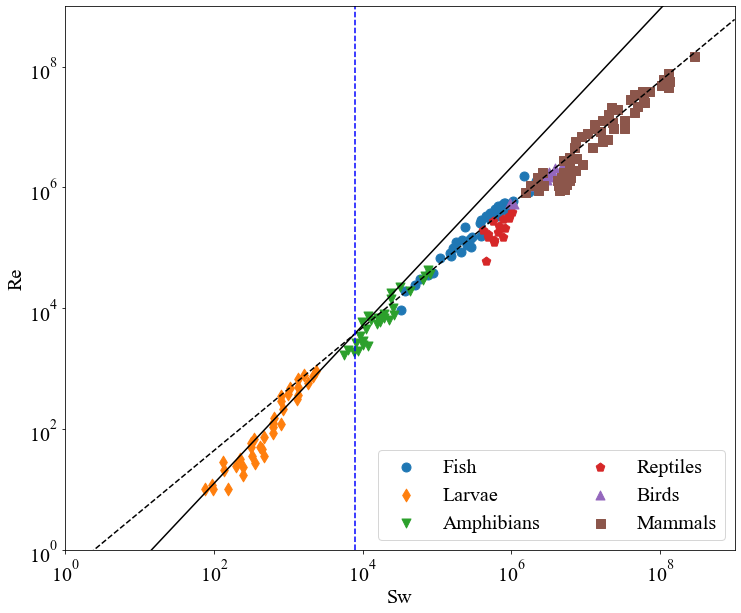

In [9]:
# plot Reynolds number and SW
fig2, ax2 = plt.subplots(figsize=(12,10), facecolor='w')

markers = ['d', 'v', 'p', '^', 's']

ax2.scatter(bio['Sw'], bio['Re'], marker='o', label='Fish')

for i, mode in enumerate(bio_modes):
    ax2.scatter(gazzola_bio_dfs[i]['Sw'], gazzola_bio_dfs[i]['Re'], marker=markers[i], label=mode  )


dx = np.linspace(1, 1e9)
Re_low = 0.03*dx**1.31
Re_high = 0.4*dx**1.02

ax2.plot(dx, Re_low, 'k-')
ax2.plot(dx, Re_high, 'k--')
ax2.plot([8e3, 8e3], [1, 1e9], 'b--')

ax2.set_xlabel('Sw')
ax2.set_ylabel('Re')
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim([1, 1e9])
ax2.set_xlim([1, 1e9])
ax2.legend(ncol=2)
#fig2.savefig('biological_sw.pdf', facecolor='w', dpi=300, bbox_inches='tight')

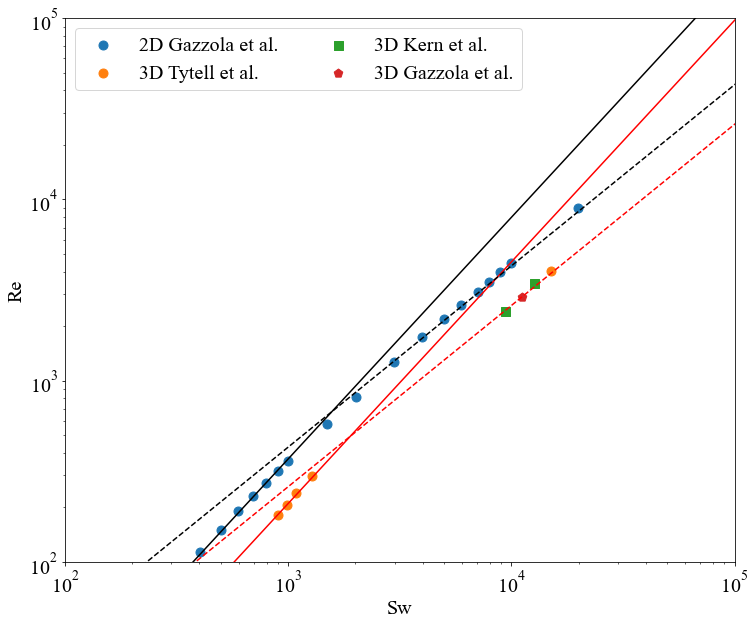

In [10]:
# plot Reynolds number and SW
fig3, ax3 = plt.subplots(figsize=(12,10), facecolor='w')

markers = ['o', 's', 'p', '^', 's']

for i, mode in enumerate(sim_modes):
    references = gazzola_sim_dfs[i]['Reference'].unique()
    gazzola_reference_dfs = [gazzola_sim_dfs[i][gazzola_sim_dfs[i]['Reference']==reference] for reference in references]
    for i, reference in enumerate(references):
        ax3.scatter(gazzola_reference_dfs[i]['Sw'], gazzola_reference_dfs[i]['Re'], marker=markers[i], label=mode + ' ' + reference)


dx = np.linspace(1, 1e9)
Re_low = 0.021*dx**(4/3)
Re_high = 0.26*dx

ax3.plot(dx, Re_low, 'r-')
ax3.plot(dx, Re_high, 'r--')

Re_low = 0.037*dx**(4/3)
Re_high = 0.43*dx

ax3.plot(dx, Re_low, 'k-')
ax3.plot(dx, Re_high, 'k--')

ax3.set_xlabel('Sw')
ax3.set_ylabel('Re')
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim([1e2, 1e5])
ax3.set_xlim([1e2, 1e5])
ax3.legend(ncol=2)
#fig3.savefig('simulation_sw.pdf', facecolor='w', dpi=300, bbox_inches='tight')

In [11]:
data_path = Path(dataBase_path, AUV_file)
auv_simDF = pd.read_excel(data_path, sheet_name='AUV Data')

# break up the data frame into perspective locomotion modes
auvs = auv_simDF['Model'].unique()
auv_sim_dfs = [auv_simDF[auv_simDF['Model']==mode] for mode in auvs]

auvDF_1 = auv_simDF[auv_simDF['Number Thrusters']==1]
auvDF_2 = auv_simDF[auv_simDF['Number Thrusters']==2]

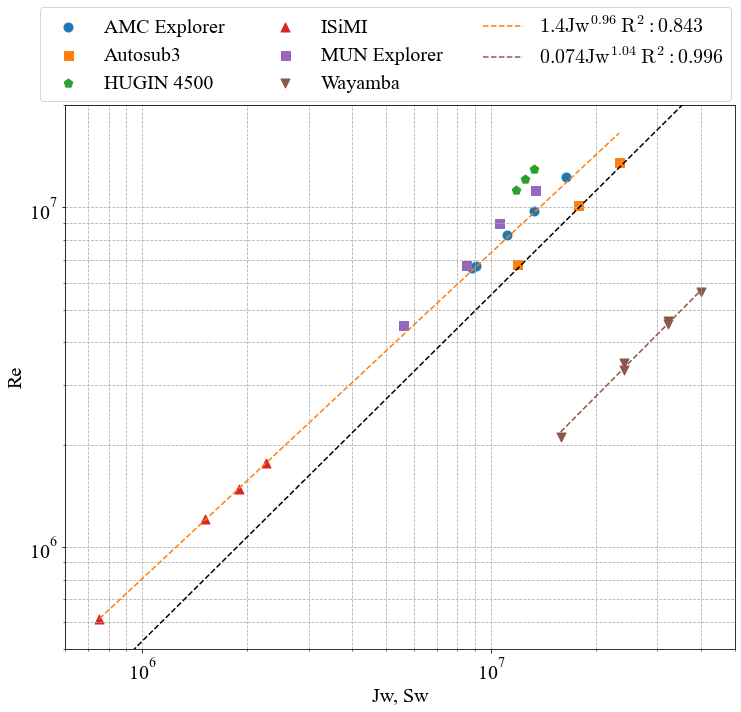

In [12]:
# plot Reynolds number and SW
fig4, ax4 = plt.subplots(figsize=(12,10), facecolor='w')

markers = ['o', 's', 'p', '^', 's', 'v']

model = PowerLawModel(prefix='p_')

Jw_1 = auvDF_1['Jw'].values
Jw_2 = auvDF_2['Jw'].values

Jw_1_index = np.argsort(Jw_1)
Jw_2_index = np.argsort(Jw_2)

Jw_1 = Jw_1[Jw_1_index]
Jw_2 = Jw_2[Jw_2_index]

Re_1 = auvDF_1['Re'].values[Jw_1_index]
Re_2 = auvDF_2['Re'].values[Jw_2_index]

pars_1 = model.guess(Re_1, x=Jw_1)
pars_1['p_amplitude'].set(value=1.40, min=0.001, max=10.0)
pars_1['p_exponent'].set(value=0.96, min=0.9, max=1.0)

pars_2 = model.guess(Re_2, x=Jw_2)
pars_2['p_amplitude'].set(value=0.07, min=0.001, max=500.0)
pars_2['p_exponent'].set(value=1.04, min=0.001, max=1.5)

Jw_fit_1 = model.fit(Re_1, pars_1, x=Jw_1)
Jw_fit_2 = model.fit(Re_2, pars_2, x=Jw_2)

amplitude = 1.40
exponent = 0.96
r_squared = np.array([calc_rsquared(Jw_1, Re_1, amplitude, exponent), 
                      calc_rsquared(Jw_2, Re_2, Jw_fit_2.params['p_amplitude'], Jw_fit_2.params['p_exponent'])])

for i, mode in enumerate(auvs):
        ax4.scatter(auv_sim_dfs[i]['Jw'], auv_sim_dfs[i]['Re'], marker=markers[i], label=mode)
        
# ax4.plot(Jw_1, Jw_fit_1.params['p_amplitude'].value*Jw_1**Jw_fit_1.params['p_exponent'].value, 'C1' + '--', label='$\mathrm{' + str(np.round(Jw_fit_1.params['p_amplitude'].value, 1)) + 
#         'Jw^{' + str(np.round(Jw_fit_1.params['p_exponent'].value, 2)) + '}\;R^2: ' + str(np.round(1 - Jw_fit_1.redchi / np.var(Re_1, ddof=2), 3)) + '}$')
ax4.plot(Jw_1, amplitude*Jw_1**exponent, 'C1' + '--', label='$\mathrm{' + str(np.round(amplitude, 3)) + 
        'Jw^{' + str(np.round(exponent, 2)) + '}\;R^2: ' + str(np.round(r_squared[0], 3)) + '}$')
ax4.plot(Jw_2, Jw_fit_2.params['p_amplitude'].value*Jw_2**Jw_fit_2.params['p_exponent'].value, 'C5' + '--', label='$\mathrm{' + str(np.round(Jw_fit_2.params['p_amplitude'].value, 3)) + 
        'Jw^{' + str(np.round(Jw_fit_2.params['p_exponent'].value, 2)) + '}\;R^2: ' + str(np.round(1 - Jw_fit_2.redchi / np.var(Re_2, ddof=2), 3)) + '}$')

dx = np.linspace(1, 1e9)
Re_low = 0.03*dx**1.31
Re_high = 0.4*dx**1.02

#ax5.plot(dx, Re_low, 'k-')
ax4.plot(dx, Re_high, 'k--')
ax4.plot([8e3, 8e3], [1, 1e9], 'b--')

ax4.set_xlabel('Jw, Sw')
ax4.set_ylabel('Re')
ax4.set_yscale('log')
ax4.set_xscale('log')
ax4.set_ylim([5e5, 2e7])
ax4.set_xlim([6e5, 5e7])
ax4.grid(which='both', linestyle='--')
ax4.legend(ncol=3, loc=4, bbox_to_anchor=(1.01, 0.99))
#fig4.savefig('AUV_jw_sw_noBlades.pdf', facecolor='w', dpi=300, bbox_inches='tight')

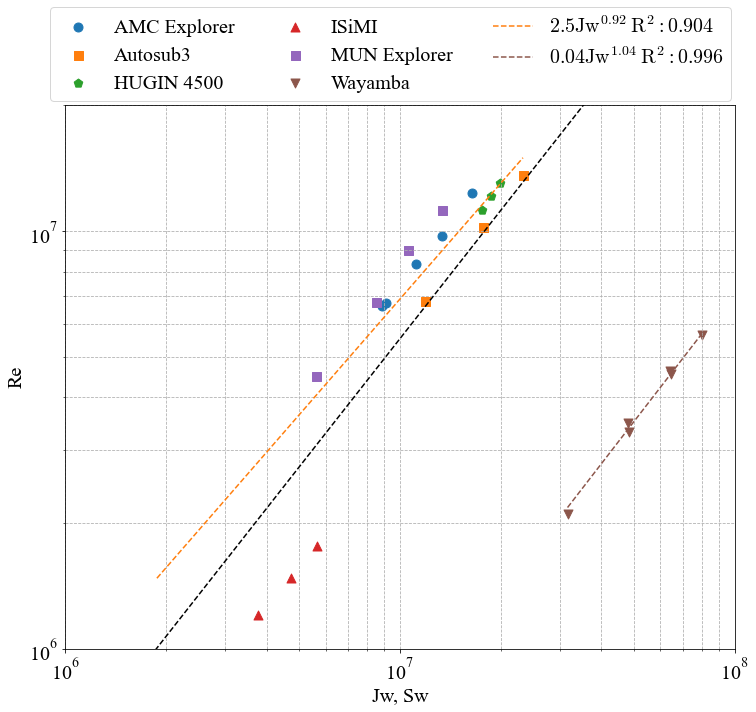

In [13]:
# plot Reynolds number and SW
fig5, ax5 = plt.subplots(figsize=(12,10), facecolor='w')

markers = ['o', 's', 'p', '^', 's', 'v']

model = PowerLawModel(prefix='p_')

Jw_1 = np.multiply(auvDF_1['Jw'].values, np.divide(auvDF_1['Number Blades'].values, 2))
Jw_2 = np.multiply(auvDF_2['Jw'].values, np.divide(auvDF_2['Number Blades'].values, 2))

Jw_1_index = np.argsort(Jw_1)
Jw_2_index = np.argsort(Jw_2)

Jw_1 = Jw_1[Jw_1_index]
Jw_2 = Jw_2[Jw_2_index]

Re_1 = auvDF_1['Re'].values[Jw_1_index]
Re_2 = auvDF_2['Re'].values[Jw_2_index]

pars_1 = model.guess(Re_1, x=Jw_1)
pars_1['p_amplitude'].set(value=16.5868, min=0.001, max=500.0)
pars_1['p_exponent'].set(value=0.811, min=0.001, max=1.5)

pars_2 = model.guess(Re_2, x=Jw_2)
pars_2['p_amplitude'].set(value=0.04297, min=0.001, max=500.0)
pars_2['p_exponent'].set(value=1.06897, min=0.001, max=1.5)

Jw_fit_1 = model.fit(Re_1, pars_1, x=Jw_1)
Jw_fit_2 = model.fit(Re_2, pars_2, x=Jw_2)

for i, mode in enumerate(auvs):
    ax5.scatter(np.multiply(auv_sim_dfs[i]['Jw'].values, np.divide(auv_sim_dfs[i]['Number Blades'].values,2)), auv_sim_dfs[i]['Re'], marker=markers[i], label=mode)

ax5.plot(Jw_1, Jw_fit_1.params['p_amplitude'].value*Jw_1**Jw_fit_1.params['p_exponent'].value, 'C1' + '--', label='$\mathrm{' + str(np.round(Jw_fit_1.params['p_amplitude'].value, 1)) + 
        'Jw^{' + str(np.round(Jw_fit_1.params['p_exponent'].value, 2)) + '}\;R^2: ' + str(np.round(1 - Jw_fit_1.redchi / np.var(Re_1, ddof=2), 3)) + '}$')
ax5.plot(Jw_2, Jw_fit_2.params['p_amplitude'].value*Jw_2**Jw_fit_2.params['p_exponent'].value, 'C5' + '--', label='$\mathrm{' + str(np.round(Jw_fit_2.params['p_amplitude'].value, 2)) + 
        'Jw^{' + str(np.round(Jw_fit_2.params['p_exponent'].value, 2)) + '}\;R^2: ' + str(np.round(1 - Jw_fit_2.redchi / np.var(Re_2, ddof=2), 3)) + '}$')

dx = np.linspace(1, 1e9)
Re_low = 0.03*dx**1.31
Re_high = 0.4*dx**1.02

#ax5.plot(dx, Re_low, 'k-')
ax5.plot(dx, Re_high, 'k--')

ax5.set_xlabel('Jw, Sw')
ax5.set_ylabel('Re')
ax5.set_yscale('log')
ax5.set_xscale('log')
ax5.set_ylim([1e6, 2e7])
ax5.set_xlim([1e6, 1e8])
ax5.grid(which='both', linestyle='--')
ax5.legend(ncol=3, loc=4, bbox_to_anchor=(1.01, 0.99))
#fig5.savefig('AUV_jw_sw_withBlades.pdf', facecolor='w', dpi=300, bbox_inches='tight')